## Evalute state overlap

The SWAP test is a quantum subroutine that can estimate the squared inner product between the two states $|\langle\psi| \phi\rangle|^2$ to $\varepsilon$ additive error by taking the average over $O\left(1/\varepsilon^2\right)$ runs. It takes two input states $|\phi\rangle$ and $|\psi\rangle$ and outputs a random variable that is 1 with probability $(1-|\langle\psi| \phi\rangle|^2)/2$.

### Benchmark SWAP test for random state overlap

State overlap (SWAP test) = 0.03584799999999999
State overlap (exact) = 0.03614930579974432


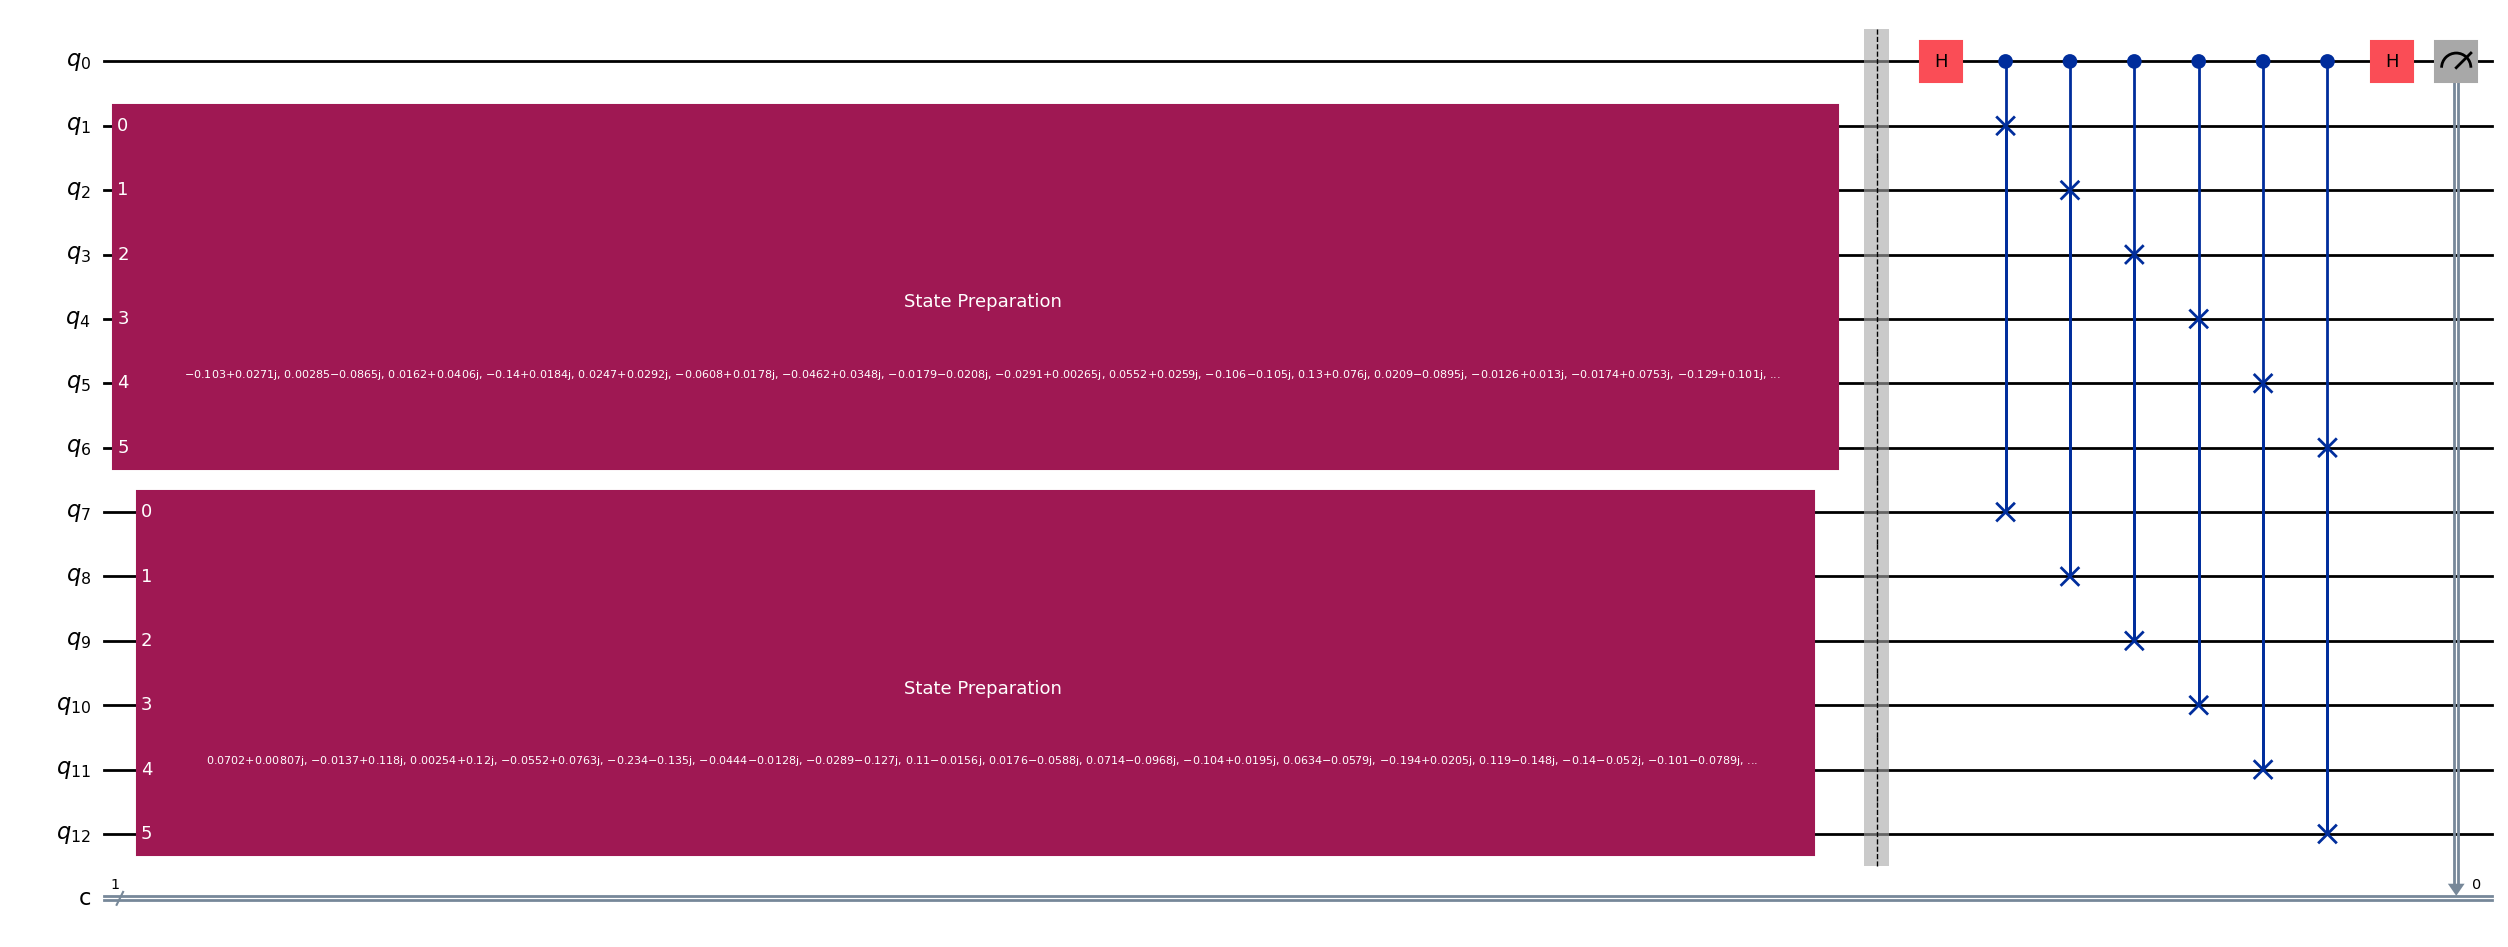

In [1]:
import hadamard_random_forest as hrf
from qiskit_aer import AerSimulator
from qiskit.circuit.library import RealAmplitudes

# Generate random states
num_qubits = 6
psi1 = hrf.random_statevector(num_qubits)
psi2 = hrf.random_statevector(num_qubits)

# Set number of experiment shots
shots = 1e6     # accurate to three decimal places

# Set the backend simulator
backend_sim = AerSimulator()

# Build the SWAP-test circuit
qc, overlap_est, overlap_exact = hrf.swap_test(psi1, psi2, backend=backend_sim, shots=shots)

print("State overlap (SWAP test) =", overlap_est)
print("State overlap (exact) =", overlap_exact)

# Visualize the circuit
qc.draw("mpl", fold=-1)

### Compare to HRF on noisy simulator

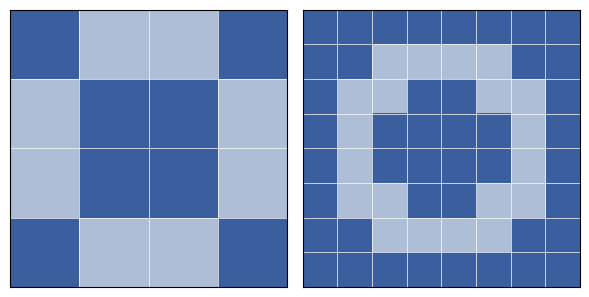


4×4 grid => flattened array of length 16.
Ring cell indices =
[1, 2, 4, 7, 8, 11, 13, 14]

8×8 grid => flattened array of length 64.
Ring cell indices =
[10, 11, 12, 13, 17, 18, 21, 22, 25, 30, 33, 38, 41, 42, 45, 46, 50, 51, 52, 53]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Grid sizes to compare
grid_sizes = [4, 8]
custom_blue = "#3A5E9E"
custom_red = "#AFBED7"

# Dictionary to store flattened ring indices for each grid
ring_flat_indices = {}

# Prepare a 2×2 subplot figure
fig, axes = plt.subplots(1, 2, figsize=(6, 6))
axes = axes.flatten()

for idx, n in enumerate(grid_sizes):
    # Create an empty n×n grid
    grid = np.zeros((n, n), dtype=int)

    # Define the (fractional) ring radii relative to n
    ring_inner_radius = n / 4.0
    ring_outer_radius = ring_inner_radius + 1.0
    x_centers = np.arange(n) + 0.5
    y_centers = np.arange(n) + 0.5
    xx, yy = np.meshgrid(x_centers, y_centers)

    # Center of the grid is (n/2, n/2)
    center = n / 2.0

    # Compute Euclidean distances from the grid center
    distances = np.sqrt((xx - center)**2 + (yy - center)**2)

    # Mark cells whose centers lie between the inner and outer radius
    mask = (distances >= ring_inner_radius) & (distances <= ring_outer_radius)
    grid[mask] = 1

    # Flatten the grid and record indices where grid == 1
    flat_indices = np.flatnonzero(grid == 1)
    ring_flat_indices[n] = flat_indices.tolist()

    # Plotting
    ax = axes[idx]
    
    # Define a custom 2-color map: 0 -> dark blue, 1 -> dark red
    cmap = ListedColormap([custom_blue, custom_red])

    # Use imshow with extent=[0,n,0,n] so each cell is displayed in a 1×1 square
    ax.imshow(
        grid,
        origin='lower',
        cmap=cmap,
        extent=[0, n, 0, n],
        interpolation='nearest'
    )

    # Draw grid lines
    ax.set_xticks(np.arange(0, n+1))
    ax.set_yticks(np.arange(0, n+1))
    ax.grid(which='both', color='white', linestyle='-', linewidth=0.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='both', which='both', length=0.001)
    
# Adjust spacing
plt.tight_layout()
plt.show()

# Print the flattened ring indices
for n in grid_sizes:
    print(f"\n{n}×{n} grid => flattened array of length {n*n}.\n"
          f"Ring cell indices =\n{ring_flat_indices[n]}")

In [3]:
from qiskit.quantum_info import Statevector

# Prepare ring state Psi_l
num_qubits = 6
vec = np.zeros(2**num_qubits)
indices = ring_flat_indices[2**(num_qubits/2)]
vec[indices] = 1
normalized_vec = vec / np.linalg.norm(vec)
psi1 = Statevector(normalized_vec)
psi1.draw(output = 'latex')

<IPython.core.display.Latex object>

In [7]:
import dill as pickle

# Load pre-generated parameters
with open('params.pkl', 'rb') as f:
    loaded_param = pickle.load(f)

# Prepare state2
num_layers = 4
ansatz = RealAmplitudes(num_qubits, entanglement='pairwise', reps=num_layers, insert_barriers=True, skip_final_rotation_layer=True)
list_circuits = hrf.get_circuits(num_qubits, ansatz)

params = loaded_param['parameter'][(num_qubits, num_layers)][3] 
ansatz.assign_parameters(params, inplace=True)
psi2 = Statevector(ansatz)

In [8]:
# Setup the noisy simulator

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeFez

backend_sim = AerSimulator.from_backend(FakeFez())

State overlap (SWAP test) = 0.002610000000000001
State overlap (exact) = 0.015803806510306044


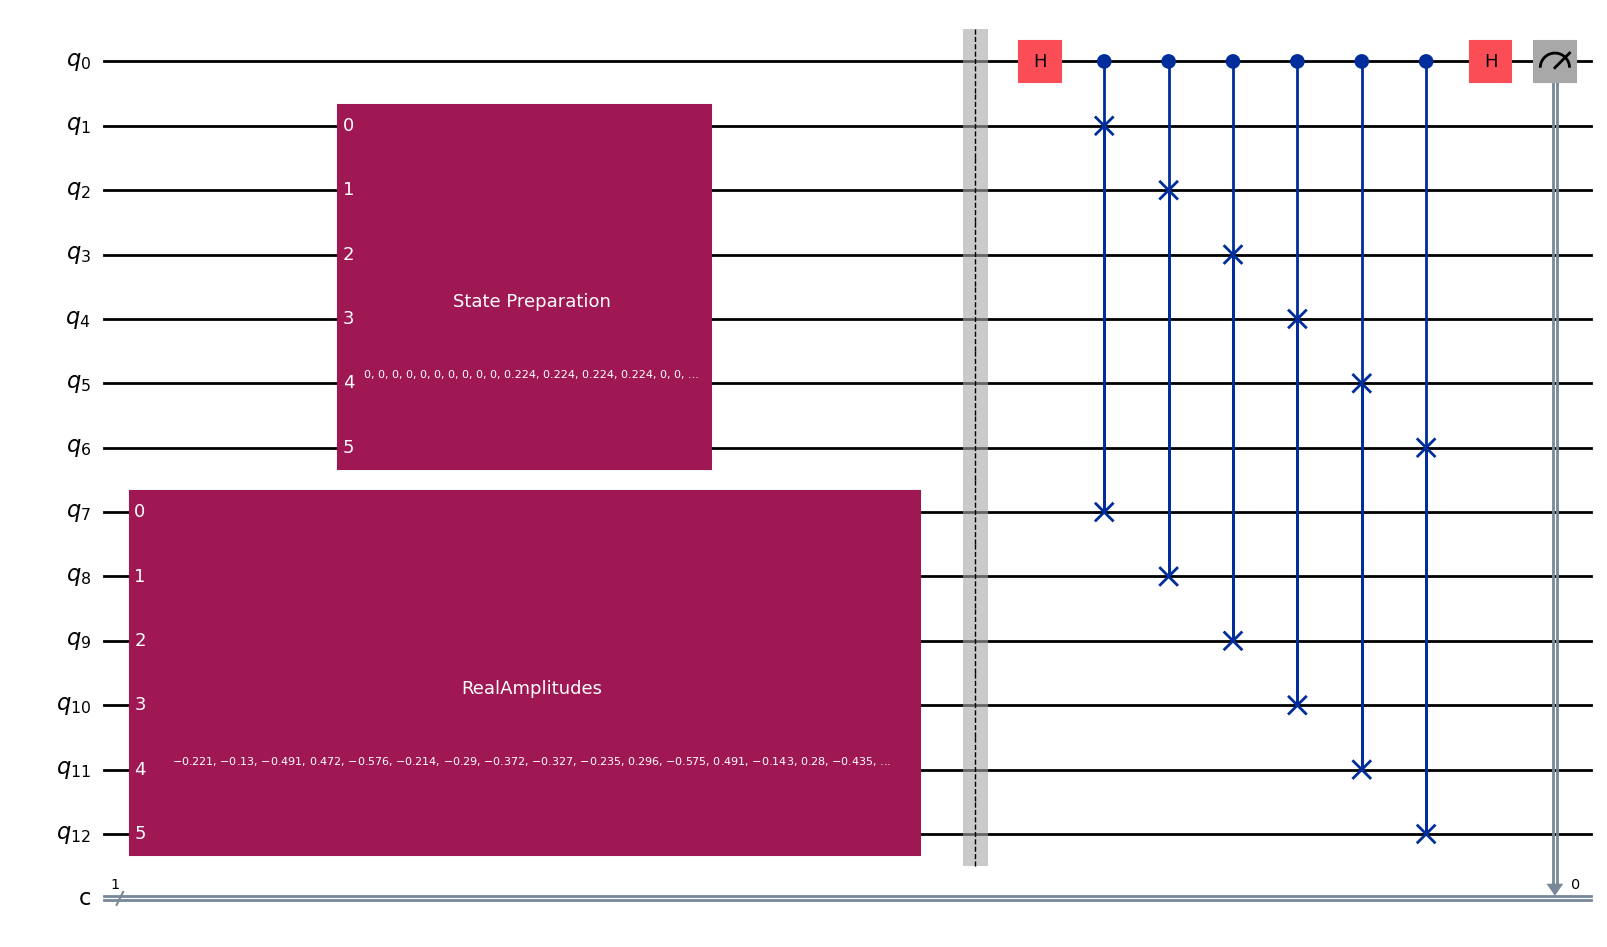

In [9]:
# Estimate overlap through the SWAP test
shots = 1e6
qc, overlap_est_noisy, overlap_exact = hrf.swap_test(psi1.data, ansatz, backend=backend_sim, shots=shots)

print("State overlap (SWAP test) =", overlap_est_noisy)
print("State overlap (exact) =", overlap_exact)

# Visualize the circuit
qc.draw("mpl", fold=-1)

In [14]:
# Use HRF to reconstruct the state2
shots = 1e6
num_trees = 111

# Collect samples
samples = hrf.get_samples_noisy(num_qubits, list_circuits, shots, params, backend_sim, error_mitigation=True)

# Reconstruct the satatevector
statevector_approx = hrf.get_statevector(num_qubits, num_trees, samples, save_tree=False, show_tree=False)

In [15]:
# Estimate state overlap
inner_hrf = np.vdot(psi1.data, statevector_approx)
overlap_est_hrf = float(abs(inner_hrf)**2)

print("State overlap (SWAP test) =", overlap_est_noisy)
print("State overlap (HRF) =", overlap_est_hrf)
print("State overlap (exact) =", overlap_exact)

State overlap (SWAP test) = 0.002610000000000001
State overlap (HRF) = 0.014987009681714283
State overlap (exact) = 0.015803806510306044


---

## Software info

In [16]:
import qiskit
import qiskit_aer
import qiskit_ibm_runtime
import mthree

print(f'Qiskit: {qiskit.__version__}')
print(f'Qiskit Aer: {qiskit_aer.__version__}')
print(f'Qiskit IBM Runtime: {qiskit_ibm_runtime.__version__}')
print(f'Mthree error mitigation: {mthree.__version__}')

Qiskit: 2.0.0
Qiskit Aer: 0.17.0
Qiskit IBM Runtime: 0.38.0
Mthree error mitigation: 3.0.0
